In [1]:
import warnings

warnings.filterwarnings("ignore")

import math
from math import sqrt

import LESS_main.less.less_reductions as ls
import LESS_main.less.less_reweighing as lsr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from fairlearn import preprocessing, reductions
from fairlearn.metrics import MetricFrame, count, selection_rate
from fairlearn.reductions import (
    BoundedGroupLoss,
    DemographicParity,
    ErrorRate,
    GridSearch,
    SquareLoss,
    ZeroOneLoss,
)
from LESS_main.less.less import LESSRegressor
from scipy.stats import kde
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from tqdm import tqdm

from fair_dummies import fair_dummies_learning, utility_functions

seed = 123

# Communities and Crime Dataset

In [2]:
# Importing communities and crime dataset
attribute_names = [
    "state numeric",
    "county numeric",
    "community numeric",
    "communityname string",
    "fold numeric",
    "population numeric",
    "householdsize numeric",
    "racepctblack numeric",
    "racePctWhite numeric",
    "racePctAsian numeric",
    "racePctHisp numeric",
    "agePct12t21 numeric",
    "agePct12t29 numeric",
    "agePct16t24 numeric",
    "agePct65up numeric",
    "numbUrban numeric",
    "pctUrban numeric",
    "medIncome numeric",
    "pctWWage numeric",
    "pctWFarmSelf numeric",
    "pctWInvInc numeric",
    "pctWSocSec numeric",
    "pctWPubAsst numeric",
    "pctWRetire numeric",
    "medFamInc numeric",
    "perCapInc numeric",
    "whitePerCap numeric",
    "blackPerCap numeric",
    "indianPerCap numeric",
    "AsianPerCap numeric",
    "OtherPerCap numeric",
    "HispPerCap numeric",
    "NumUnderPov numeric",
    "PctPopUnderPov numeric",
    "PctLess9thGrade numeric",
    "PctNotHSGrad numeric",
    "PctBSorMore numeric",
    "PctUnemployed numeric",
    "PctEmploy numeric",
    "PctEmplManu numeric",
    "PctEmplProfServ numeric",
    "PctOccupManu numeric",
    "PctOccupMgmtProf numeric",
    "MalePctDivorce numeric",
    "MalePctNevMarr numeric",
    "FemalePctDiv numeric",
    "TotalPctDiv numeric",
    "PersPerFam numeric",
    "PctFam2Par numeric",
    "PctKids2Par numeric",
    "PctYoungKids2Par numeric",
    "PctTeen2Par numeric",
    "PctWorkMomYoungKids numeric",
    "PctWorkMom numeric",
    "NumIlleg numeric",
    "PctIlleg numeric",
    "NumImmig numeric",
    "PctImmigRecent numeric",
    "PctImmigRec5 numeric",
    "PctImmigRec8 numeric",
    "PctImmigRec10 numeric",
    "PctRecentImmig numeric",
    "PctRecImmig5 numeric",
    "PctRecImmig8 numeric",
    "PctRecImmig10 numeric",
    "PctSpeakEnglOnly numeric",
    "PctNotSpeakEnglWell numeric",
    "PctLargHouseFam numeric",
    "PctLargHouseOccup numeric",
    "PersPerOccupHous numeric",
    "PersPerOwnOccHous numeric",
    "PersPerRentOccHous numeric",
    "PctPersOwnOccup numeric",
    "PctPersDenseHous numeric",
    "PctHousLess3BR numeric",
    "MedNumBR numeric",
    "HousVacant numeric",
    "PctHousOccup numeric",
    "PctHousOwnOcc numeric",
    "PctVacantBoarded numeric",
    "PctVacMore6Mos numeric",
    "MedYrHousBuilt numeric",
    "PctHousNoPhone numeric",
    "PctWOFullPlumb numeric",
    "OwnOccLowQuart numeric",
    "OwnOccMedVal numeric",
    "OwnOccHiQuart numeric",
    "RentLowQ numeric",
    "RentMedian numeric",
    "RentHighQ numeric",
    "MedRent numeric",
    "MedRentPctHousInc numeric",
    "MedOwnCostPctInc numeric",
    "MedOwnCostPctIncNoMtg numeric",
    "NumInShelters numeric",
    "NumStreet numeric",
    "PctForeignBorn numeric",
    "PctBornSameState numeric",
    "PctSameHouse85 numeric",
    "PctSameCity85 numeric",
    "PctSameState85 numeric",
    "LemasSwornFT numeric",
    "LemasSwFTPerPop numeric",
    "LemasSwFTFieldOps numeric",
    "LemasSwFTFieldPerPop numeric",
    "LemasTotalReq numeric",
    "LemasTotReqPerPop numeric",
    "PolicReqPerOffic numeric",
    "PolicPerPop numeric",
    "RacialMatchCommPol numeric",
    "PctPolicWhite numeric",
    "PctPolicBlack numeric",
    "PctPolicHisp numeric",
    "PctPolicAsian numeric",
    "PctPolicMinor numeric",
    "OfficAssgnDrugUnits numeric",
    "NumKindsDrugsSeiz numeric",
    "PolicAveOTWorked numeric",
    "LandArea numeric",
    "PopDens numeric",
    "PctUsePubTrans numeric",
    "PolicCars numeric",
    "PolicOperBudg numeric",
    "LemasPctPolicOnPatr numeric",
    "LemasGangUnitDeploy numeric",
    "LemasPctOfficDrugUn numeric",
    "PolicBudgPerPop numeric",
    "ViolentCrimesPerPop numeric",
]
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
    names=attribute_names,
)

# Replacing missing values with Nan
df = df.replace("?", np.nan)

# Creating binary sensitive variable
# Condition: % black greater than % white, % asian and % hispanic
df["race_dummy"] = np.where(
    (df["racepctblack numeric"] > df["racePctWhite numeric"])
    & (df["racepctblack numeric"] > df["racePctAsian numeric"])
    & (df["racepctblack numeric"] > df["racePctHisp numeric"]),
    1,
    0,
)

# Keeping all predictive columns
keep = [
    "racePctWhite numeric",
    "OtherPerCap numeric",
    "PctBSorMore numeric",
    "PctKids2Par numeric",
    "PctWorkMom numeric",
    "PctIlleg numeric",
    "PctImmigRec8 numeric",
    "PctLargHouseFam numeric",
    "MedRentPctHousInc numeric",
    "NumStreet numeric",
    "PopDens numeric",
    "state numeric",
    "ViolentCrimesPerPop numeric",
    "race_dummy",
]

df = df[keep]

df["OtherPerCap numeric"] = pd.to_numeric(df["OtherPerCap numeric"])

df.head()

,racePctWhite numeric,OtherPerCap numeric,PctBSorMore numeric,PctKids2Par numeric,PctWorkMom numeric,PctIlleg numeric,PctImmigRec8 numeric,PctLargHouseFam numeric,MedRentPctHousInc numeric,NumStreet numeric,PopDens numeric,state numeric,ViolentCrimesPerPop numeric,race_dummy
0,0.90,0.36,0.48,0.59,0.76,0.14,0.37,0.14,0.38,0.0,0.26,8,0.20,0
1,0.74,0.22,0.30,0.47,0.53,0.24,0.64,0.16,0.29,0.0,0.12,53,0.67,0
2,0.56,0.28,0.19,0.44,0.67,0.46,0.15,0.20,0.48,0.0,0.21,24,0.43,0
3,0.08,0.36,0.31,0.54,0.86,0.33,0.30,0.56,0.63,0.0,0.39,34,0.12,1
4,0.95,0.51,0.33,0.91,0.60,0.06,0.20,0.16,0.22,0.0,0.09,42,0.03,0


In [3]:
# Establishing dependent and independent variables
X = list(df.columns)
Y = X[len(X) - 2]

del X[len(X) - 2]
Y, X

train_df = df.dropna()

In [4]:
# Generating train-test split
X_train, X_test, y_train, y_test = train_test_split(
    train_df[X], train_df[Y], test_size=0.3, random_state=seed
)

In [5]:
X_train = X_train[
    ["race_dummy"] + [col for col in X_train.columns if col != "race_dummy"]
]
X_test = X_test[["race_dummy"] + [col for col in X_test.columns if col != "race_dummy"]]

# Models

## Baseline Model Training

### Linear Regression Baseline

In [6]:
linreg_baseline = LinearRegression()
linreg_baseline.fit(X_train, y_train)
y_linreg_baseline_pred = linreg_baseline.predict(X_test)

### LESS Baseline

In [7]:
LESS_model = LESSRegressor(frac=0.2, random_state=seed)
LESS_model.fit(X_train, y_train)
y_pred_baseline = LESS_model.predict(X_test)

100%|██████████| 20/20 [00:00<00:00, 158.84it/s]


## Correlation Remover

Remove Correlation from our training X. Cannot be done for test set as technically don't have y of test set

In [8]:
# Object used to remove correlation
correlation_remover_train = preprocessing.CorrelationRemover(
    sensitive_feature_ids=["race_dummy"]
)
correlation_remover_train.fit(X_train, y_train)

# Removing correlation from our training set
X_train_uncorr = correlation_remover_train.transform(X_train)
X_train_uncorr_wr = np.concatenate(
    (np.array(X_train["race_dummy"]).reshape(-1, 1), X_train_uncorr), axis=1
)

### Linear Regression with Correlation Remover

In [9]:
linreg_uncorr = LinearRegression()
linreg_uncorr.fit(X_train_uncorr_wr, y_train)
y_linreg_uncorr_pred = linreg_uncorr.predict(X_test)

### LESS with Correlation Remover

In [10]:
LESS_model_uncorr_wr = LESSRegressor(frac=0.2, random_state=seed)
LESS_model_uncorr_wr.fit(X_train_uncorr_wr, y_train)
y_pred_uncorr_wr = LESS_model_uncorr_wr.predict(X_test)

100%|██████████| 20/20 [00:00<00:00, 152.00it/s]


## Discretisation and Reweighting

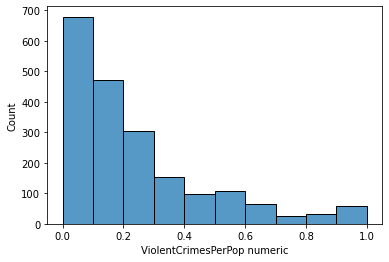

In [11]:
# Distribution of outcome variable
sns.histplot(df[Y], kde=False, bins=10)
plt.show()

In [12]:
# Generating a column for outcome class
est = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="uniform")
Y_np = train_df[Y].to_numpy().reshape(-1, 1)
est.fit(Y_np)
df_Yt = est.transform(Y_np)

df_rw = train_df.copy()
df_rw["ViolentCrimesPerPop class"] = df_Yt.reshape(-1)
df_rw.head()

,racePctWhite numeric,OtherPerCap numeric,PctBSorMore numeric,PctKids2Par numeric,PctWorkMom numeric,PctIlleg numeric,PctImmigRec8 numeric,PctLargHouseFam numeric,MedRentPctHousInc numeric,NumStreet numeric,PopDens numeric,state numeric,ViolentCrimesPerPop numeric,race_dummy,ViolentCrimesPerPop class
0,0.90,0.36,0.48,0.59,0.76,0.14,0.37,0.14,0.38,0.0,0.26,8,0.20,0,2.0
1,0.74,0.22,0.30,0.47,0.53,0.24,0.64,0.16,0.29,0.0,0.12,53,0.67,0,6.0
2,0.56,0.28,0.19,0.44,0.67,0.46,0.15,0.20,0.48,0.0,0.21,24,0.43,0,4.0
3,0.08,0.36,0.31,0.54,0.86,0.33,0.30,0.56,0.63,0.0,0.39,34,0.12,1,1.0
4,0.95,0.51,0.33,0.91,0.60,0.06,0.20,0.16,0.22,0.0,0.09,42,0.03,0,0.0


In [13]:
# Establishing dependent and independent variables
columns = list(df_rw.columns)
y_rw = df_rw[columns[-3]]
del columns[-3]
X_rw = df_rw[columns]

# Generating train-test split
X_train_rw, X_test_rw, y_train_rw, y_test_rw = train_test_split(
    X_rw, y_rw, test_size=0.3, random_state=seed
)

In [14]:
# Lists of sensitive attribute values and outcome classes
sensitive = list(X_train_rw["race_dummy"].unique())
label = list(X_train_rw["ViolentCrimesPerPop class"].unique())

In [15]:
# Calculating weights for each combination of sensitive attribute value
# and outcome class using Kamiran-Calders algorithm
weights = {}
for i in tqdm(sensitive):
    for j in label:
        if (
            len(X_train_rw)
            * len(
                X_train_rw[
                    (X_train_rw["race_dummy"] == i)
                    & (X_train_rw["ViolentCrimesPerPop class"] == j)
                ]
            )
        ) == 0:
            weights[(i, j)] = 0
        else:
            weights[(i, j)] = (
                len(X_train_rw[X_train_rw["race_dummy"] == i])
                * len(X_train_rw[X_train_rw["ViolentCrimesPerPop class"] == j])
            ) / (
                len(X_train_rw)
                * len(
                    X_train_rw[
                        (X_train_rw["race_dummy"] == i)
                        & (X_train_rw["ViolentCrimesPerPop class"] == j)
                    ]
                )
            )

100%|██████████| 2/2 [00:00<00:00, 32.34it/s]


In [16]:
# Creating new column for sample weights
def get_weights(a, b):
    return weights[(a, b)]


X_train_rw["weights"] = X_train_rw.apply(
    lambda x: get_weights(x["race_dummy"], x["ViolentCrimesPerPop class"]), axis=1
)

### Reweighing with Linear Regression

In [17]:
linreg_rw = LinearRegression()
linreg_rw.fit(X_train_rw[X], y_train_rw, X_train_rw["weights"])
y_linreg_pred_rw = linreg_rw.predict(X_test_rw[X])

### Reweighing with LESS

In [18]:
LESS_model_rw = lsr.LESSRegressor(frac=0.2, random_state=seed)
LESS_model_rw.fit(X_train_rw[X], y_train_rw, X_train_rw["weights"])
y_pred_rw = LESS_model_rw.predict(X_test_rw[X])

### Hyperparameter Tuning for Reweighing (strategies and number of bins)

In [19]:
Y_np = train_df[Y].to_numpy().reshape(-1, 1)
y_rw = train_df[Y]
X_rw = train_df[X]

# List of bin numbers to try
bins = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# List of two binning strategies to try
strategies = ["uniform", "quantile"]
weights = {}

df_predictions_weights = pd.DataFrame(
    {"Actual": y_test, "Sensitive Attribute": X_test["race_dummy"],}
)


def get_weights(a, b):
    return weights[(a, b)]


for s in strategies:
    for b in bins:
        est = KBinsDiscretizer(n_bins=b, encode="ordinal", strategy=s)
        est.fit(Y_np)
        df_Yt = est.transform(Y_np)
        X_rw["ViolentCrimesPerPop class"] = df_Yt.reshape(-1)

        X_train_rw, X_test_rw, y_train_rw, y_test_rw = train_test_split(
            X_rw, y_rw, test_size=0.3, random_state=seed
        )

        sensitive = list(X_train_rw["race_dummy"].unique())
        label = list(X_train_rw["ViolentCrimesPerPop class"].unique())
        sensitive, label

        weights = {}
        for i in sensitive:
            for j in label:
                if (
                    len(X_train_rw)
                    * len(
                        X_train_rw[
                            (X_train_rw["race_dummy"] == i)
                            & (X_train_rw["ViolentCrimesPerPop class"] == j)
                        ]
                    )
                ) == 0:
                    weights[(i, j)] = 0
                else:
                    weights[(i, j)] = (
                        len(X_train_rw[X_train_rw["race_dummy"] == i])
                        * len(X_train_rw[X_train_rw["ViolentCrimesPerPop class"] == j])
                    ) / (
                        len(X_train_rw)
                        * len(
                            X_train_rw[
                                (X_train_rw["race_dummy"] == i)
                                & (X_train_rw["ViolentCrimesPerPop class"] == j)
                            ]
                        )
                    )

        X_train_rw["weights"] = X_train_rw.apply(
            lambda x: get_weights(x["race_dummy"], x["ViolentCrimesPerPop class"]),
            axis=1,
        )

        # Fitting model with sample weights associated with given combination
        # of bin number and binning strategy
        LESS_model_rw = lsr.LESSRegressor(frac=0.2, random_state=seed)
        LESS_model_rw.fit(X_train_rw[X], y_train_rw, X_train_rw["weights"])
        y_pred_rw = LESS_model_rw.predict(X_test_rw[X])

        # Evaluating accuracy and fairness
        df_predictions_weights["Predicted"] = y_pred_rw
        df_predictions_weights = df_predictions_weights.reset_index(drop=True)
        df_predictions_weights_zero = df_predictions_weights[
            df_predictions_weights["Sensitive Attribute"] == 0
        ]
        df_predictions_weights_one = df_predictions_weights[
            df_predictions_weights["Sensitive Attribute"] == 1
        ]

        print(
            "Test error of LESS with "
            + str(b)
            + " bins, using "
            + s
            + " strategy: {0:.4f}".format(
                math.sqrt(
                    mean_squared_error(
                        df_predictions_weights["Predicted"],
                        df_predictions_weights["Actual"],
                    )
                )
            )
        )
        print(
            "Group RMSE ratio using LESS with "
            + str(b)
            + " bins, using "
            + s
            + " strategy: {0:.4f}".format(
                math.sqrt(
                    mean_squared_error(
                        df_predictions_weights_one["Predicted"],
                        df_predictions_weights_one["Actual"],
                    )
                )
                / math.sqrt(
                    mean_squared_error(
                        df_predictions_weights_zero["Predicted"],
                        df_predictions_weights_zero["Actual"],
                    )
                )
            )
        )
        print(
            "Group ME difference using LESS with "
            + str(b)
            + " bins, using "
            + s
            + " strategy: {0:.4f}".format(
                (
                    df_predictions_weights_one["Predicted"]
                    - df_predictions_weights_one["Actual"]
                ).mean()
                - (
                    df_predictions_weights_zero["Predicted"]
                    - df_predictions_weights_zero["Actual"]
                ).mean()
            )
        )
    print("-----------------------------------------------------")

Test error of LESS with 2 bins, using uniform strategy: 0.1430
Group RMSE ratio using LESS with 2 bins, using uniform strategy: 1.5885
Group ME difference using LESS with 2 bins, using uniform strategy: -0.0393
Test error of LESS with 3 bins, using uniform strategy: 0.1446
Group RMSE ratio using LESS with 3 bins, using uniform strategy: 1.6180
Group ME difference using LESS with 3 bins, using uniform strategy: -0.0637
Test error of LESS with 4 bins, using uniform strategy: 0.1442
Group RMSE ratio using LESS with 4 bins, using uniform strategy: 1.5861
Group ME difference using LESS with 4 bins, using uniform strategy: -0.0546
Test error of LESS with 5 bins, using uniform strategy: 0.1445
Group RMSE ratio using LESS with 5 bins, using uniform strategy: 1.5947
Group ME difference using LESS with 5 bins, using uniform strategy: -0.0571
Test error of LESS with 6 bins, using uniform strategy: 0.1448
Group RMSE ratio using LESS with 6 bins, using uniform strategy: 1.6066
Group ME difference u

## Fair Dummies Training (Romano) 

### Parameter Selection (From Romano paper)

### Fair Dummies LESS

In [20]:
# Fair Dummies hyperparameters
in_shape = X_train.shape[1] - 1
batch_size = 10000
lr_loss = 0.01
lr_dis = 0.01
loss_steps = 80
dis_steps = 80
mu_val = 0.7
second_scale = 1
epochs = 20
cost_pred = torch.nn.MSELoss()
model_type = "linear_model"

# Fitting model
loc_est = lambda: fair_dummies_learning.EquiRegLearner(
    lr=lr_loss,
    pretrain_pred_epochs=0,
    pretrain_dis_epochs=0,
    epochs=epochs,
    loss_steps=loss_steps,
    dis_steps=dis_steps,
    cost_pred=cost_pred,
    in_shape=in_shape,
    batch_size=batch_size,
    model_type=model_type,
    lambda_vec=mu_val,
    second_moment_scaling=second_scale,
    out_shape=1,
)

LESS_model_equireg = LESSRegressor(
    local_estimator=loc_est, frac=0.2, equireg=True, random_state=seed
)

LESS_model_equireg.fit(np.array(X_train), y_train)
dummies_pred = LESS_model_equireg.predict(np.array(X_test))

100%|██████████| 20/20 [09:41<00:00, 29.09s/it]


### Linear Regression Fair Dummies

In [21]:
FD_model = fair_dummies_learning.EquiRegLearner(
    lr=lr_loss,
    pretrain_pred_epochs=0,
    pretrain_dis_epochs=0,
    epochs=epochs,
    loss_steps=loss_steps,
    dis_steps=dis_steps,
    cost_pred=cost_pred,
    in_shape=in_shape,
    batch_size=batch_size,
    model_type=model_type,
    lambda_vec=mu_val,
    second_moment_scaling=second_scale,
    out_shape=1,
)

FD_model.fit(np.array(X_train), y_train)
Lin_reg_FD_pred = FD_model.predict(np.array(X_test))

### Uncorrelated Variables with Fair Dummies

In [22]:
LESS_model_equireg_uncorr = LESSRegressor(
    local_estimator=loc_est, frac=0.2, equireg=True, random_state=seed
)
LESS_model_equireg_uncorr.fit(X_train_uncorr_wr, y_train)
dummies_uncorr_pred = LESS_model_equireg_uncorr.predict(np.array(X_test))

100%|██████████| 20/20 [10:27<00:00, 31.35s/it]


 ### Uncorrelated with Fair Dummies Linear Regression   

In [23]:
FD_model_uncorr = fair_dummies_learning.EquiRegLearner(
    lr=lr_loss,
    pretrain_pred_epochs=0,
    pretrain_dis_epochs=0,
    epochs=epochs,
    loss_steps=loss_steps,
    dis_steps=dis_steps,
    cost_pred=cost_pred,
    in_shape=in_shape,
    batch_size=batch_size,
    model_type=model_type,
    lambda_vec=mu_val,
    second_moment_scaling=second_scale,
    out_shape=1,
)

FD_model_uncorr.fit(np.array(X_train_uncorr_wr), y_train)
Lin_reg_FD_uncorr_pred = FD_model_uncorr.predict(np.array(X_test))

## Bounded Group Loss(Agarwal)

### Bounded group loss model

In [24]:
# Defining bounded group loss constraint
bgl1 = BoundedGroupLoss(SquareLoss(0, 1), upper_bound=0.05)

# Fitting model
reduction = GridSearch(LinearRegression(), constraints=bgl1, grid_size=100)
reduction.fit(
    X_train[X].drop("race_dummy", axis=1),
    y_train,
    sensitive_features=X_train["race_dummy"],
)
y_pred_BGL_only = reduction.predict(X_test[X].drop("race_dummy", axis=1))

### LESS with BGL

In [25]:
df_predictions_LESS_BGL_tuned = pd.DataFrame(
    {"Actual": y_test, "Sensitive Attribute": X_test["race_dummy"],}
)

LESS_model_BGL_tuned = ls.LESSRegressor(frac=0.2, random_state=seed)
LESS_model_BGL_tuned.fit(X_train, y_train, "race_dummy", gridsize=100)
y_pred_BGL_LESS_tuned = LESS_model_BGL_tuned.predict(X_test)

100%|██████████| 20/20 [05:23<00:00, 16.15s/it]


### Hyperparameter Tuning: Grid size and Upper bound

In [26]:
# List of grid sizes to try
gridsize = [25, 50, 100, 200, 500]
df_predictions_gridsizes = pd.DataFrame(
    {"Actual": y_test, "Sensitive Attribute": X_test["race_dummy"],}
)

for g in gridsize:
    LESS_model_BGL = ls.LESSRegressor(frac=0.2, random_state=seed)
    LESS_model_BGL.fit(X_train, y_train, "race_dummy", gridsize=g)
    y_pred_BGL_LESS = LESS_model_BGL.predict(X_test)

    df_predictions_gridsizes["Predicted"] = y_pred_BGL_LESS
    df_predictions_gridsizes = df_predictions_gridsizes.reset_index(drop=True)
    df_predictions_gridsizes_zero = df_predictions_gridsizes[
        df_predictions_gridsizes["Sensitive Attribute"] == 0
    ]
    df_predictions_gridsizes_one = df_predictions_gridsizes[
        df_predictions_gridsizes["Sensitive Attribute"] == 1
    ]

    print(
        "Test error of LESS with gridsize "
        + str(g)
        + ": {0:.4f}".format(
            math.sqrt(
                mean_squared_error(
                    df_predictions_gridsizes["Predicted"],
                    df_predictions_gridsizes["Actual"],
                )
            )
        )
    )
    print(
        "Group RMSE ratio using LESS with gridsize "
        + str(g)
        + ": {0:.4f}".format(
            math.sqrt(
                mean_squared_error(
                    df_predictions_gridsizes_one["Predicted"],
                    df_predictions_gridsizes_one["Actual"],
                )
            )
            / math.sqrt(
                mean_squared_error(
                    df_predictions_gridsizes_zero["Predicted"],
                    df_predictions_gridsizes_zero["Actual"],
                )
            )
        )
    )
    print(
        "Group ME Difference using LESS with gridsize "
        + str(g)
        + ": {0:.4f}".format(
            (
                df_predictions_gridsizes_one["Predicted"]
                - df_predictions_gridsizes_one["Actual"]
            ).mean()
            - (
                df_predictions_gridsizes_zero["Predicted"]
                - df_predictions_gridsizes_zero["Actual"]
            ).mean()
        )
    )

100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Test error of LESS with gridsize 25: 0.1429
Group RMSE ratio using LESS with gridsize 25: 1.5676
Group ME Difference using LESS with gridsize 25: 0.0022


100%|██████████| 20/20 [02:16<00:00,  6.82s/it]


Test error of LESS with gridsize 50: 0.1428
Group RMSE ratio using LESS with gridsize 50: 1.5676
Group ME Difference using LESS with gridsize 50: 0.0031


100%|██████████| 20/20 [03:51<00:00, 11.59s/it]


Test error of LESS with gridsize 100: 0.1429
Group RMSE ratio using LESS with gridsize 100: 1.5665
Group ME Difference using LESS with gridsize 100: 0.0020


100%|██████████| 20/20 [07:57<00:00, 23.85s/it]


Test error of LESS with gridsize 200: 0.1428
Group RMSE ratio using LESS with gridsize 200: 1.5672
Group ME Difference using LESS with gridsize 200: 0.0021


100%|██████████| 20/20 [23:58<00:00, 71.93s/it]

Test error of LESS with gridsize 500: 0.1428
Group RMSE ratio using LESS with gridsize 500: 1.5682
Group ME Difference using LESS with gridsize 500: 0.0021


### Bounded Group Loss with Uncorrelated variables

In [27]:
# Defining bounded group loss constraint
bgl_uncorr = BoundedGroupLoss(SquareLoss(0, 1), upper_bound=0.05)

# Fitting model
reduction_uncorr = GridSearch(LinearRegression(), constraints=bgl_uncorr, grid_size=100)
reduction_uncorr.fit(
    X_train_uncorr, y_train, sensitive_features=X_train["race_dummy"],
)
y_pred_BGL_uncorr = reduction_uncorr.predict(X_test[X].drop("race_dummy", axis=1))

### LESS with Bounded Group Loss and Uncorrelated Variables

In [ ]:
LESS_model_BGL_uncorr = ls.LESSRegressor(frac=0.2, random_state=seed)
LESS_model_BGL_uncorr.fit(
    pd.DataFrame(X_train_uncorr_wr, columns=X), y_train, "race_dummy", gridsize=100
)
y_pred_BGL_LESS_uncorr = LESS_model_BGL_uncorr.predict(X_test)

# Results and Plotting

In [29]:
# Creating datafram of prediction series for each model
df_predictions = pd.DataFrame(
    {
        "Baseline_Less": y_pred_baseline,
        "Baseline_Lin_reg": y_linreg_baseline_pred,
        "Uncorrelated_LESS": y_pred_uncorr_wr,
        "Uncorrelated_Lin_Reg": y_linreg_uncorr_pred,
        "Dummies_LESS": dummies_pred,
        "Dummies_Lin_Reg": Lin_reg_FD_pred,
        "BGL": y_pred_BGL_only,
        "BGL_LESS": y_pred_BGL_LESS_tuned,
        "BGL_uncorr": y_pred_BGL_uncorr,
        "BGL_LESS_uncorr": y_pred_BGL_LESS_uncorr,
        "Reweigh_LESS": y_pred_rw,
        "Reweigh_Lin_Reg": y_linreg_pred_rw,
        "FD_Uncorr_LESS": dummies_uncorr_pred,
        "FD_Uncorr_Lin_Reg": Lin_reg_FD_uncorr_pred,
        "Actual": y_test,
        "Sensitive Attribute": X_test["race_dummy"],
    }
)
df_predictions = df_predictions.reset_index(drop=True)

df_predictions.head()

,Baseline_Less,Baseline_Lin_reg,Uncorrelated_LESS,Uncorrelated_Lin_Reg,Dummies_LESS,Dummies_Lin_Reg,BGL,BGL_LESS,BGL_uncorr,BGL_LESS_uncorr,Reweigh_LESS,Reweigh_Lin_Reg,FD_Uncorr_LESS,FD_Uncorr_Lin_Reg,Actual,Sensitive Attribute
0,0.459774,0.465022,0.833434,0.834952,0.377431,0.356613,0.413318,0.455359,0.562392,0.695188,0.375587,0.235162,0.437784,0.426432,1.00,1
1,0.334271,0.314035,0.691878,0.683965,0.280868,0.205580,0.291722,0.316093,0.446950,0.690994,0.231732,0.100627,0.334457,0.320299,0.21,1
2,0.187803,0.183847,0.143685,0.140935,0.203980,0.220795,0.191099,0.183038,0.364007,0.172607,0.193459,0.206721,0.193295,0.201146,0.14,0
3,0.681806,0.660302,1.056860,1.030232,0.611475,0.526841,0.566095,0.595627,0.708927,0.850077,0.627927,0.452767,0.633649,0.569016,0.54,1
4,0.165586,0.141878,0.122134,0.098966,0.151871,0.141259,0.152224,0.132575,0.323030,0.120294,0.168118,0.173306,0.175653,0.174968,0.16,0


In [30]:
# Splitting dataframe based on value of sensitive attribute
df_predictions_zero = df_predictions[df_predictions["Sensitive Attribute"] == 0]
df_predictions_one = df_predictions[df_predictions["Sensitive Attribute"] == 1]

In [31]:
# Creating dataframe of accuracy and fairness score results for each model
Results = pd.DataFrame()
cols = df_predictions.columns
cols = cols[:-2]
MSE = []  # Mean squared error
MED = []  # Mean error difference between groups
RMSERBG = []  # Root mean squared error difference between groups

for col in cols:
    MSE.append(mean_squared_error(df_predictions[col], df_predictions["Actual"]))
    MED.append(
        (df_predictions_one[col] - df_predictions_one["Actual"]).mean()
        - (df_predictions_zero[col] - df_predictions_zero["Actual"]).mean()
    )
    RMSERBG.append(
        math.sqrt(
            mean_squared_error(df_predictions_one[col], df_predictions_one["Actual"])
        )
        / math.sqrt(
            mean_squared_error(df_predictions_zero[col], df_predictions_zero["Actual"])
        )
    )

Results = pd.DataFrame(
    {
        "Models": cols,
        "Mean Squared Error": MSE,
        "Mean Errors difference between groups": MED,
        "Root-mean-squared error ratio between groups": RMSERBG,
    }
)

Results["Root Mean Squared Error"] = Results["Mean Squared Error"].apply(
    lambda x: math.sqrt(x)
)
Results

,Models,Mean Squared Error,Mean Errors difference between groups,Root-mean-squared error ratio between groups,Root Mean Squared Error
0,Baseline_Less,0.019942,0.027038,1.631874,0.141216
1,Baseline_Lin_reg,0.020258,0.030985,1.598905,0.142329
2,Uncorrelated_LESS,0.038888,0.422352,3.304226,0.197201
3,Uncorrelated_Lin_Reg,0.041211,0.443827,3.377234,0.203004
4,Dummies_LESS,0.020323,-0.029655,1.584779,0.142557
5,Dummies_Lin_Reg,0.023776,-0.128736,1.741805,0.154195
6,BGL,0.022801,0.020859,1.530354,0.151000
7,BGL_LESS,0.020406,0.001996,1.566534,0.142850
8,BGL_uncorr,0.055889,-0.011143,1.185779,0.236409
9,BGL_LESS_uncorr,0.033031,0.331924,2.809482,0.181745


## Boxplots of group-specific prediction errors for each model

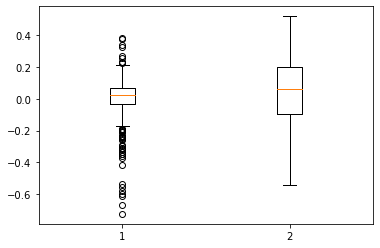

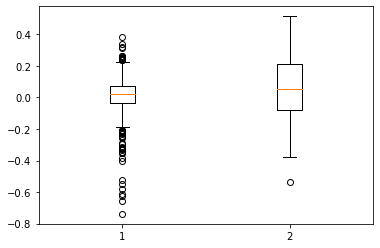

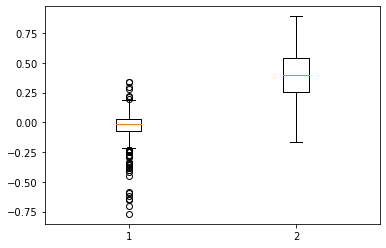

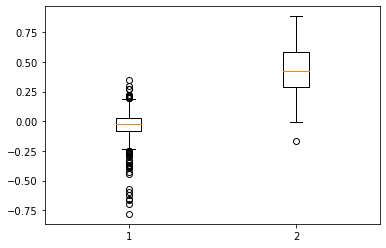

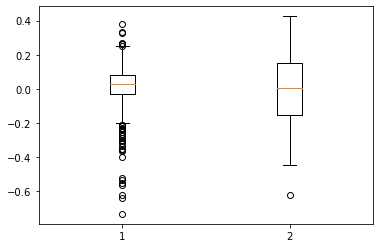

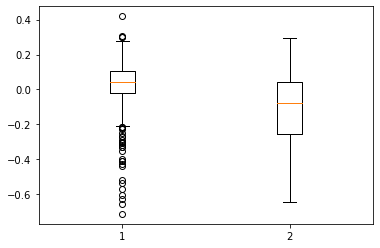

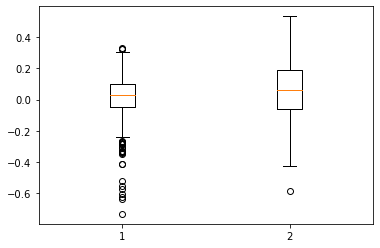

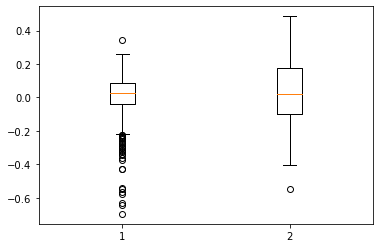

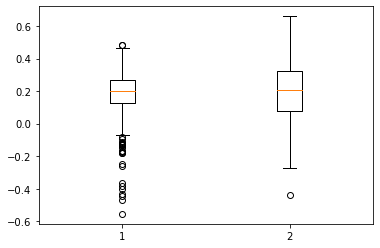

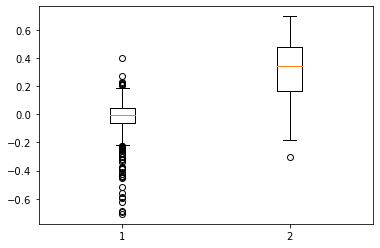

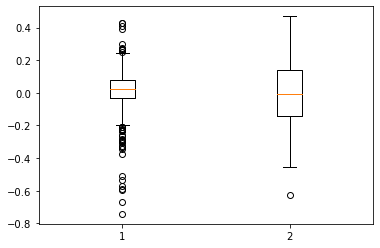

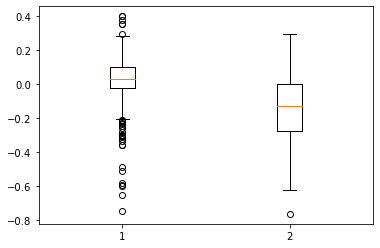

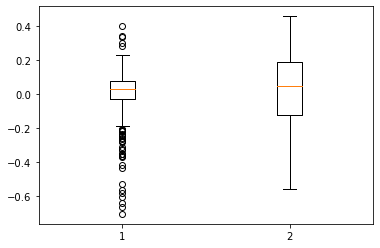

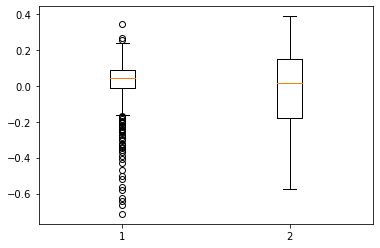

In [32]:
list_cols = list(cols)
for col in list_cols:
    fig7, ax7 = plt.subplots()
    ax7.boxplot(
        [
            (df_predictions_zero[col] - df_predictions_zero["Actual"]),
            (df_predictions_one[col] - df_predictions_one["Actual"]),
        ]
    )
    plt.show()

## Visualising the fairness-accuracy tradeoff

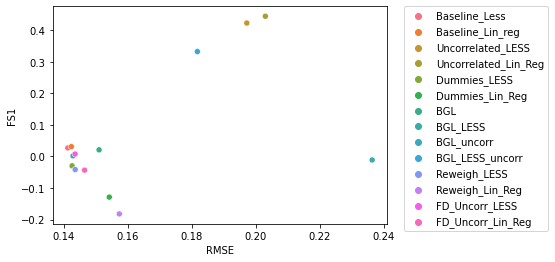

In [33]:
sns.scatterplot(
    data=Results,
    x="Root Mean Squared Error",
    y="Mean Errors difference between groups",
    hue="Models",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.xlabel("RMSE")
plt.ylabel("FS1")
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.savefig("FS1_tradeoff_CC.jpg", bbox_extra_artists=(lgd,), bbox_inches="tight")

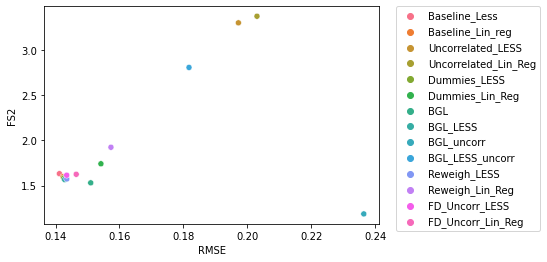

In [34]:
sns.scatterplot(
    data=Results,
    x="Root Mean Squared Error",
    y="Root-mean-squared error ratio between groups",
    hue="Models",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.xlabel("RMSE")
plt.ylabel("FS2")
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.savefig("FS2_tradeoff_CC.jpg", bbox_extra_artists=(lgd,), bbox_inches="tight")